**The Reference Catalog**

Rubin’s DP1 processing uses the **The Monster** reference catalog for both astrometric and photometric calibration. It 
is a whole-sky, LSST-specific reference catalog built from multiple surveys—most notably **DES**, **Pan-STARRS**,
and **Gaia**—with synthetic **LSST *ugrizy* fluxes**. Astrometry is provided by **Gaia DR3**.  

The main goal of this notebook is to find reference catalog files that cover the **ECDFS** region.

In [171]:
from lsst.daf.butler import Butler
from lsst.meas.algorithms.htmIndexer import HtmIndexer
import lsst.geom as geom
from lsst.afw.table import SimpleCatalog
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
import warnings
from astropy.io.fits.card import VerifyWarning
warnings.simplefilter('ignore', VerifyWarning)
import os
import matplotlib.pyplot as plt
import glob
import numpy as np

In [172]:
# Initialize the Butler for DP1 data
butler = Butler("dp1")

# List all available collections
collections = butler.registry.queryCollections()
print(collections)

['LSSTComCam/calib/DM-46360/isrTaskLSST/bfkGen.20240926a/20240927T200534Z', 'LSSTComCam/calib/DM-46360/isrTaskLSST/biasGen.20240926a/20240927T212215Z', 'LSSTComCam/calib/DM-46360/isrTaskLSST/darkGen.20240926a/20240927T213944Z', 'LSSTComCam/calib/DM-46360/isrTaskLSST/defectGen.20240926a/20240926T233116Z', 'LSSTComCam/calib/DM-46360/isrTaskLSST/flatGen-g.20240926a/20240927T230123Z', 'LSSTComCam/calib/DM-46360/isrTaskLSST/flatGen-i.20240926a/20240928T182337Z', 'LSSTComCam/calib/DM-46360/isrTaskLSST/flatGen-r.20240926a/20240927T232432Z', 'LSSTComCam/calib/DM-46360/isrTaskLSST/linearizerGen.20240926a/20240927T182910Z', 'LSSTComCam/calib/DM-46360/isrTaskLSST/ptcGen.20240926a/20240927T183452Z', 'LSSTComCam/calib/DM-47197/pseudoFlat/flatGen-i.20241028d/run', 'LSSTComCam/calib/DM-47197/pseudoFlat/flatGen-r.20241028d/run', 'LSSTComCam/calib/DM-47365/addManualDefects/defectsGen.20241121c/20241211T235712Z', 'LSSTComCam/calib/DM-47447/gainFixup/biasGen.20241107a/20241107T194536Z', 'LSSTComCam/calib

In [173]:
# Query all dataset types:
all_dts = butler.registry.queryDatasetTypes()

# Filter only dataset types whose name contains 'monster'
monster_dts = [dt for dt in all_dts if "monster" in dt.name.lower()]

# Print the filtered dataset types:
for dt in monster_dts:
    print(dt)

DatasetType('the_monster_20250219', {htm7}, SimpleCatalog)


**In this step:**

1. compute the HTM7 trixels with HtmIndexer:

   a. HTM → Hierarchical Triangular Mesh, a way to divide the celestial sphere into triangular tiles.

   b. 7 → depth level in the hierarchy. Depth 7 means the sphere has been subdivided 7 times, giving triangles about 0.46° across.

   c. Trixel ID → the unique integer that identifies one of those triangular tiles.
 
3. pull those shards from the Butler,

4. do a precise circular cut (so you only keep sources in the Chandra field),

5. write the result (one merged catalog for the field) to disk.

In [174]:
# CONFIGURE of FIELD
RA_CENTER_DEG  = 53.1      # Chandra/VIDEO center (deg)
DEC_CENTER_DEG = -27.8     # (deg)
RADIUS_DEG     = 1.5       # circular cut radius (deg)

# Compute HTM7 trixels covering the circular field
htm = HtmIndexer(depth=7)
center = geom.SpherePoint(RA_CENTER_DEG*geom.degrees, DEC_CENTER_DEG*geom.degrees)
shards, on_boundary = htm.getShardIds(center, RADIUS_DEG*geom.degrees)
htm7_ids = list(shards)
print(f"HTM7 ids covering circle: {len(htm7_ids)} -> {htm7_ids[:24]}{' ...' if len(htm7_ids)>24 else ''}")

if not htm7_ids:
    raise RuntimeError("No HTM7 trixels found for this field/radius. Double-check center/radius and collection.")

# Connect to the refcat collection
butler = Butler("dp1", collections="refcats/DM-49042/the_monster_20250219")

# Peek one shard to get schema
first_cat = butler.get("the_monster_20250219", dataId={"htm7": htm7_ids[0]})
final_cat = SimpleCatalog(first_cat.schema)

# Fetch shards and keep only sources inside the exact circle
center_coord = SkyCoord(RA_CENTER_DEG*u.deg, DEC_CENTER_DEG*u.deg)

kept = 0
for tid in htm7_ids:
    cat = butler.get("the_monster_20250219", dataId={"htm7": tid})
    # Fast loop; LSST Angle -> degrees for SkyCoord
    for rec in cat:
        ra_deg  = rec.get("coord_ra").asDegrees()
        dec_deg = rec.get("coord_dec").asDegrees()
        if center_coord.separation(SkyCoord(ra_deg*u.deg, dec_deg*u.deg)).deg <= RADIUS_DEG:
            final_cat.append(rec)
            kept += 1

print(f"Total Monster sources inside circle: {kept}")

# make sure the data directory exists

# save to disk
out_fits = "data/the_monster_20250219/monster_chandra_circle.fits"
final_cat.writeFits(out_fits)
print(f"Wrote: {out_fits}")

HTM7 ids covering circle: 24 -> [np.int64(147048), np.int64(147049), np.int64(147051), np.int64(147172), np.int64(147174), np.int64(147175), np.int64(147028), np.int64(147042), np.int64(147050), np.int64(147052), np.int64(147053), np.int64(147055), np.int64(147056), np.int64(147057), np.int64(147059), np.int64(147144), np.int64(147169), np.int64(147173), np.int64(147180), np.int64(147182), np.int64(147183), np.int64(147188), np.int64(147190), np.int64(147191)]
Total Monster sources inside circle: 25015
Wrote: data/the_monster_20250219/monster_chandra_circle.fits


**Merged catalog** is useful here because: easy to crossmatch, compute color terms, propagate positions, dedupe, etc.

But Butler ingestion expects the refcats datasetType to be sharded by htm7 (that’s how the_monster_20250219 is stored).

Here we produce HTM7-sharded files (24 individual refcat_htm7_Id.fits; matching LSST’s shard layout).

In [175]:
# Connect to the RSP butler 
butler = Butler("dp1", collections="refcats/DM-49042/the_monster_20250219")

# HTM7 IDs covering your Chandra circle 
htm7_ids = [147048, 147049, 147051, 147172, 147174, 147175, 
            147028, 147042, 147050, 147052, 147053, 147055, 
            147056, 147057, 147059, 147144, 147169, 147173, 
            147180, 147182, 147183, 147188, 147190, 147191]

for tid in htm7_ids: 
    cat = butler.get("the_monster_20250219", dataId={"htm7": tid}) 
    # Convert LSST catalog to Astropy Table 
    t = Table(cat.asAstropy()) 
    filename = f"data/the_monster_20250219/refcat_htm7_{tid}.fits" 
    t.write(filename, overwrite=True) 
    print(f"Saved {filename} with {len(t)} sources.")

Saved data/the_monster_20250219/refcat_htm7_147048.fits with 1705 sources.
Saved data/the_monster_20250219/refcat_htm7_147049.fits with 1670 sources.
Saved data/the_monster_20250219/refcat_htm7_147051.fits with 1624 sources.
Saved data/the_monster_20250219/refcat_htm7_147172.fits with 1759 sources.
Saved data/the_monster_20250219/refcat_htm7_147174.fits with 1779 sources.
Saved data/the_monster_20250219/refcat_htm7_147175.fits with 1720 sources.
Saved data/the_monster_20250219/refcat_htm7_147028.fits with 1634 sources.
Saved data/the_monster_20250219/refcat_htm7_147042.fits with 1789 sources.
Saved data/the_monster_20250219/refcat_htm7_147050.fits with 1638 sources.
Saved data/the_monster_20250219/refcat_htm7_147052.fits with 1618 sources.
Saved data/the_monster_20250219/refcat_htm7_147053.fits with 1717 sources.
Saved data/the_monster_20250219/refcat_htm7_147055.fits with 1715 sources.
Saved data/the_monster_20250219/refcat_htm7_147056.fits with 1907 sources.
Saved data/the_monster_20

**Plot refcat catalogs**

1. Reads all FITS catalogs matching refcat_htm7_*.fits.

2. Converts coord_ra/coord_dec to degrees if needed.

3. Plots each catalog in a different color with small points.

4. Adds a legend to identify each HTM7 trixel.

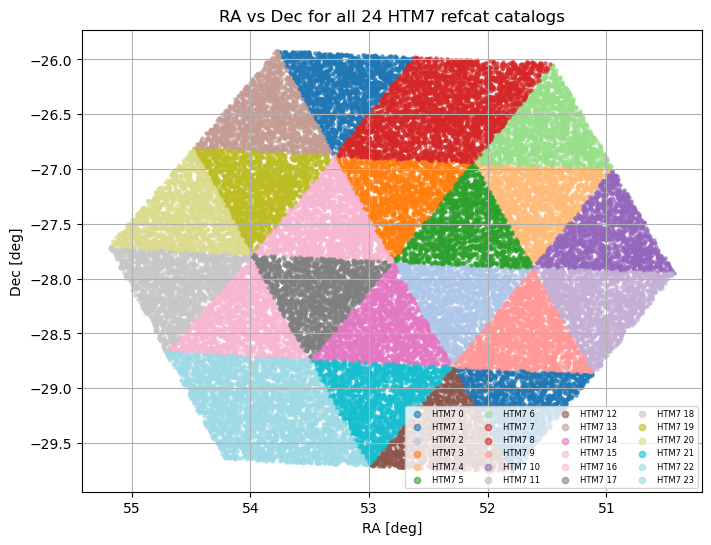

In [176]:
# Path to 24 FITS catalogs
fits_files = sorted(glob.glob("data/the_monster_20250219/refcat_htm7_*.fits"))

plt.figure(figsize=(8,6))
colors = plt.cm.tab20(np.linspace(0,1,len(fits_files)))  # colormap for different catalogs

for i, fits_file in enumerate(fits_files):
    # Read FITS table
    cat = Table.read(fits_file)

    # coord_ra, coord_dec might be in radians in LSST catalogs
    if np.max(cat['coord_ra']) > 2*np.pi:
        # Already in degrees
        ra_deg = cat['coord_ra']
        dec_deg = cat['coord_dec']
    else:
        # Convert radians to degrees
        ra_deg = np.degrees(cat['coord_ra'])
        dec_deg = np.degrees(cat['coord_dec'])

    plt.scatter(ra_deg, dec_deg, s=5, color=colors[i], label=f'HTM7 {i}', alpha=0.6)

plt.gca().invert_xaxis()
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("RA vs Dec for all 24 HTM7 refcat catalogs")
plt.legend(markerscale=2, fontsize=6, ncol=4)
plt.grid(True)
plt.show()